In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt


def target_PDF(likelihood, prior, n, h, theta):
    
    if theta < 0 or theta > 1:
        return 0
    else:
        
        # 似然概率
        likelihood_fcn = likelihood(n, theta).pmf(h)
        # 先验概率
        prior_fcn = prior.pdf(theta)
        # 后验概率
        posterior_fcn = likelihood_fcn * prior_fcn
        return posterior_fcn


def data_generator(num_iterations, n, s,
                   theta_0, likelihood, prior,
                   drop_unstable=True,
                   sigma=0.3):
    # container for sample data
    # samples = np.zeros(num_iterations + 1)
    # samples[0] = theta_0
    samples = [theta_0]

    num_accepted = 0

    theta_now = theta_0

    for idx in range(num_iterations):
        
        # 从均值为 0、标准差为 sigma 的正态分布中抽取一个随机样本
        # .rvs 会从分布中抽取一个或多个随机样本
        delta_theta = stats.norm(0, sigma).rvs()
        # 计算下一个样本值
        theta_next = theta_now + delta_theta
        # 计算起始点的概率密度
        numerator = target_PDF(likelihood, prior, n, s, theta_next)
        # 计算当前点的概率密度
        denominator = target_PDF(likelihood, prior, n, s, theta_now)
        # 计算接受率
        rho = min(1, numerator / denominator)
        
        # 产生随机数
        u_idx = np.random.uniform()
        
        # 如果当前点和起始点的概率密度的比值大于随机数则接收当前点
        if u_idx < rho:
            num_accepted += 1
            theta_now = theta_next

        # samples[idx + 1] = theta_now
        samples.append(theta_now)

        # 计算接收效率
        efficiency = num_accepted / num_iterations

    if drop_unstable:
        nmcmc = len(samples) // 2
        samples = samples[nmcmc:]

    return samples



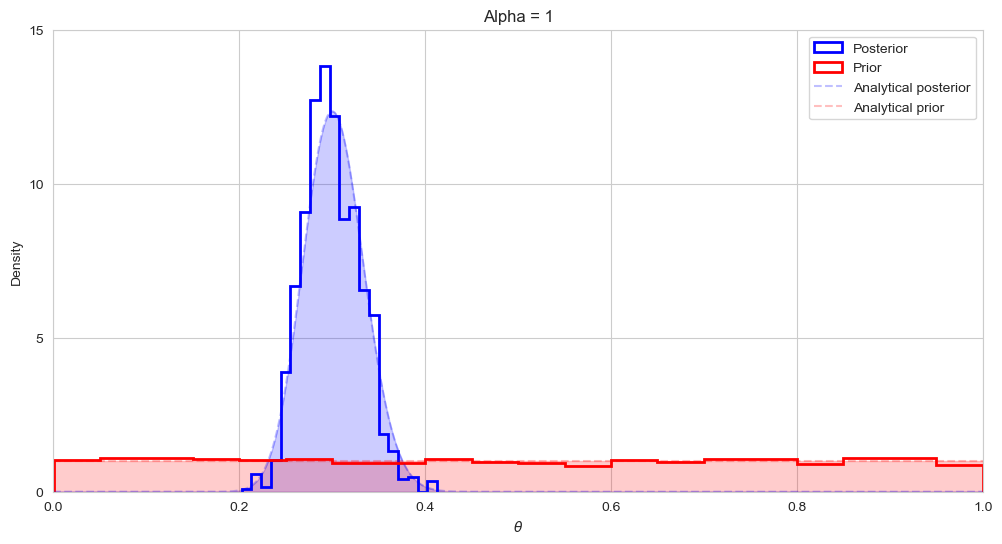

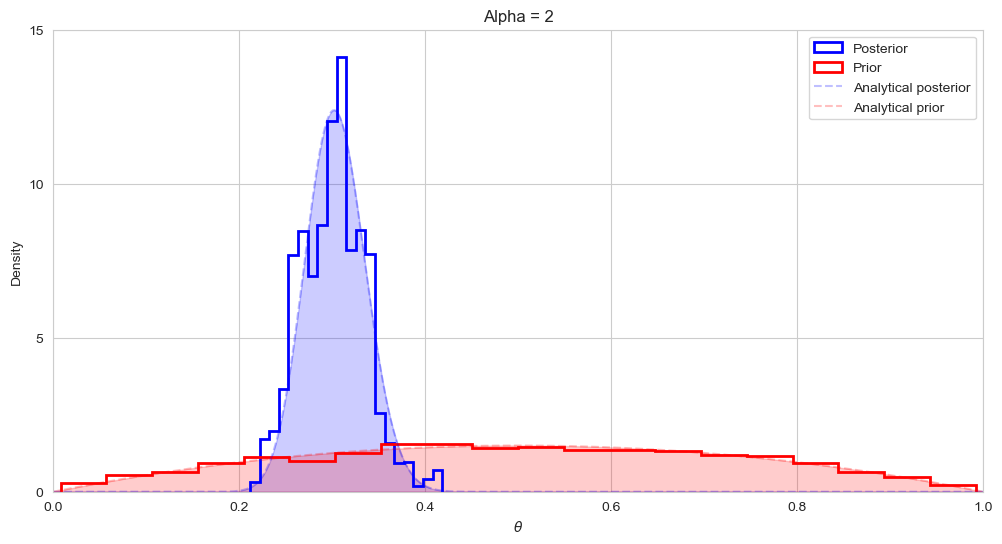

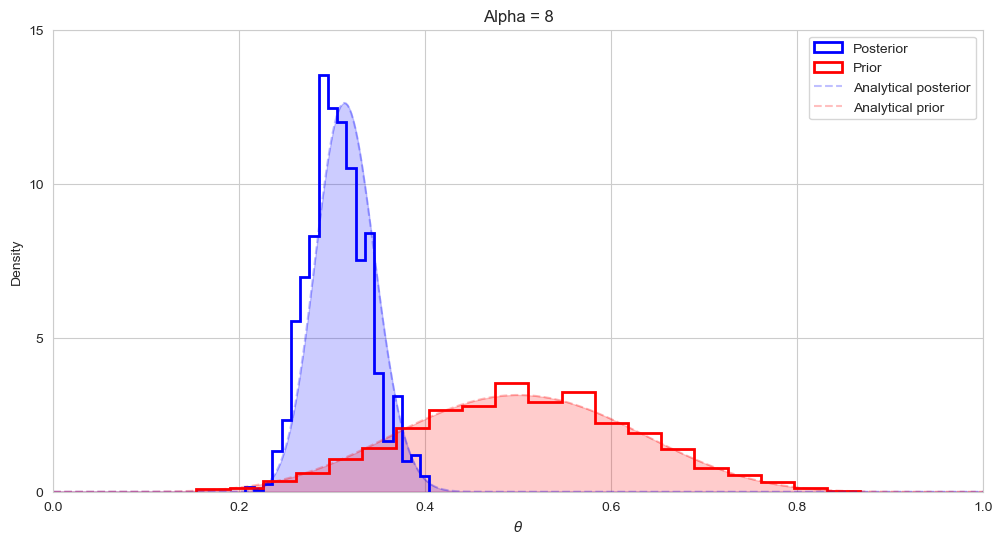

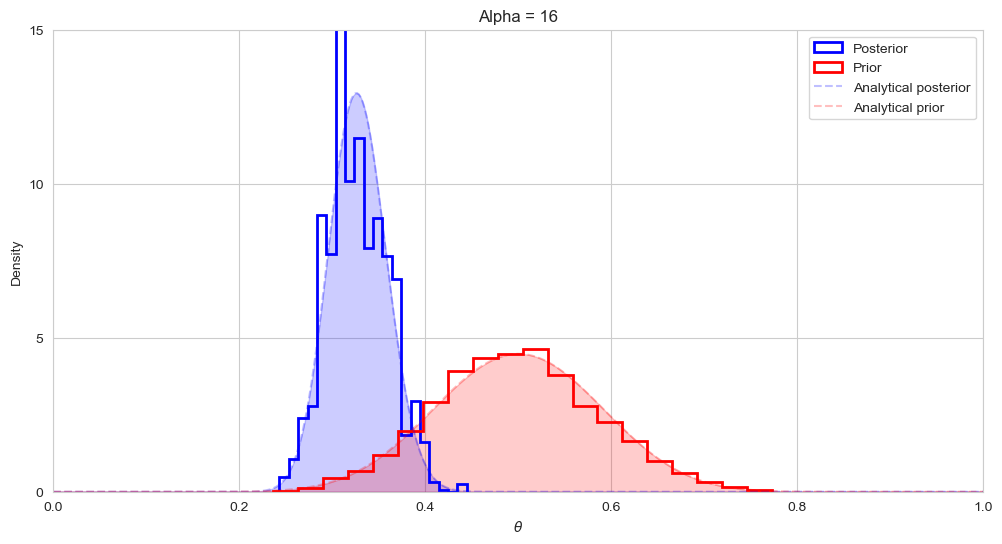

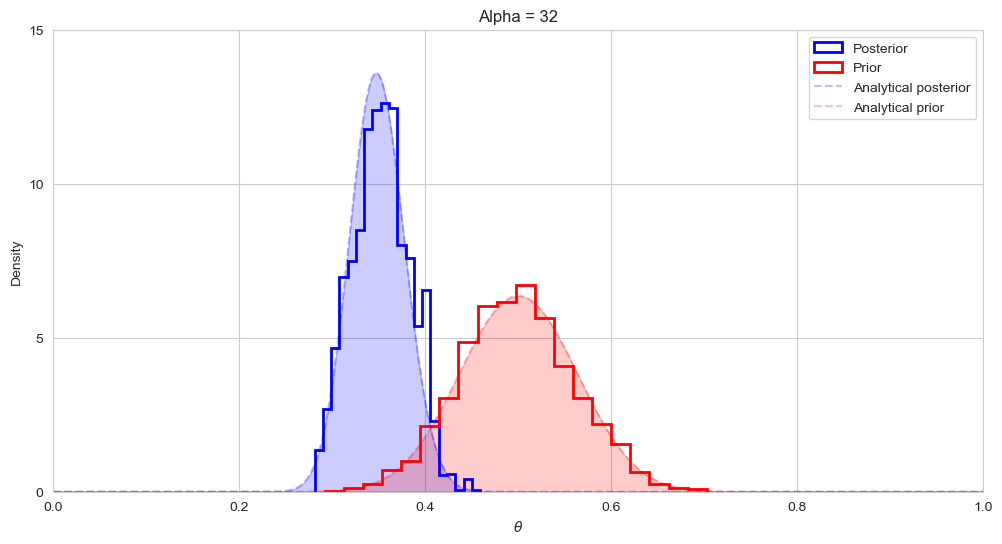

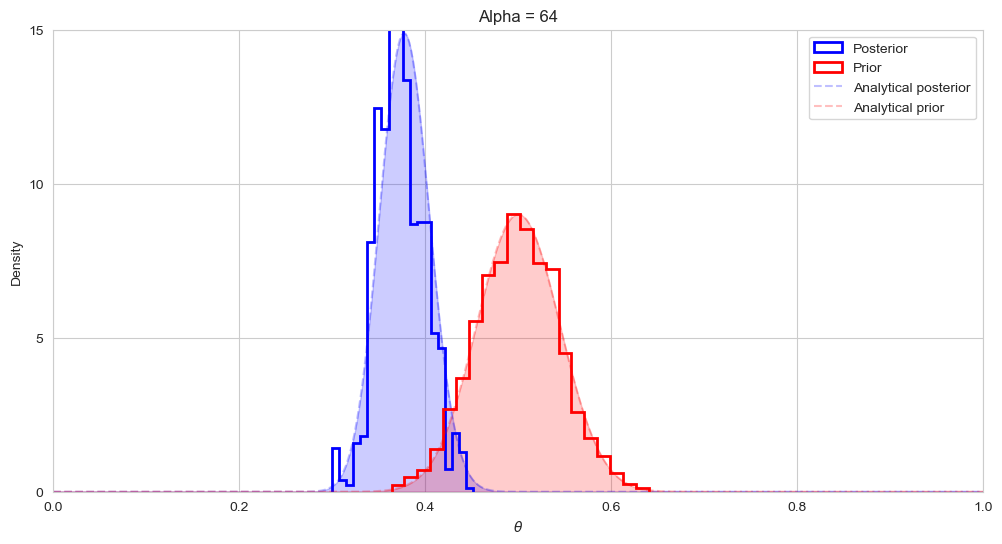

In [3]:
theta_array = np.linspace(0, 1, 500)

# number of animal samples:
n = 200

# number of rabbits in data:
s = 60

# initiall guess
theta_0 = 0.1

# number of iterations
num_iterations = 5000

# prior distribution
# assumption: 1:1 ratio
# i.e., alpha = beta in Beta(alpha, beta) distribution

alpha_arrays = [1, 2, 8, 16, 32, 64]

for alpha in alpha_arrays:
    
    beta = alpha

    # distributions
    likelihood = stats.binom
    prior = stats.beta(alpha, beta)
    post = stats.beta(s + alpha, n - s + beta)
    # analytical to compare with 

    # generate random data
    samples = data_generator(num_iterations, n, s,
                             theta_0, likelihood, prior)

    # compare analytical vs samples

    fig, ax = plt.subplots(figsize=(12, 6))

    plt.hist(samples, 20, histtype='step',
             density=True, linewidth=2,
             color='b',
             label='Posterior');

    plt.hist(prior.rvs(len(samples)), 20, histtype='step',
             density=True, linewidth=2,
             color='r',
             label='Prior');

    plt.plot(theta_array, post.pdf(theta_array),
             c='b', linestyle='--', alpha=0.25,
             label='Analytical posterior')
    plt.fill_between(theta_array, 0, post.pdf(theta_array),
                     color='b',
                     alpha=0.2)

    plt.plot(theta_array, prior.pdf(theta_array),
             c='r', linestyle='--', alpha=0.25,
             label='Analytical prior')
    plt.fill_between(theta_array, 0, prior.pdf(theta_array),
                     color='r',
                     alpha=0.2)

    plt.xlim([0, 1])
    plt.ylim([0, 15])
    plt.yticks([0, 5, 10, 15])
    plt.legend(loc='best')
    plt.xlabel(r'$\theta$')
    plt.ylabel('Density')
    plt.title('Alpha = %0.0f' % alpha)


Text(0, 0.5, '$\\theta$')

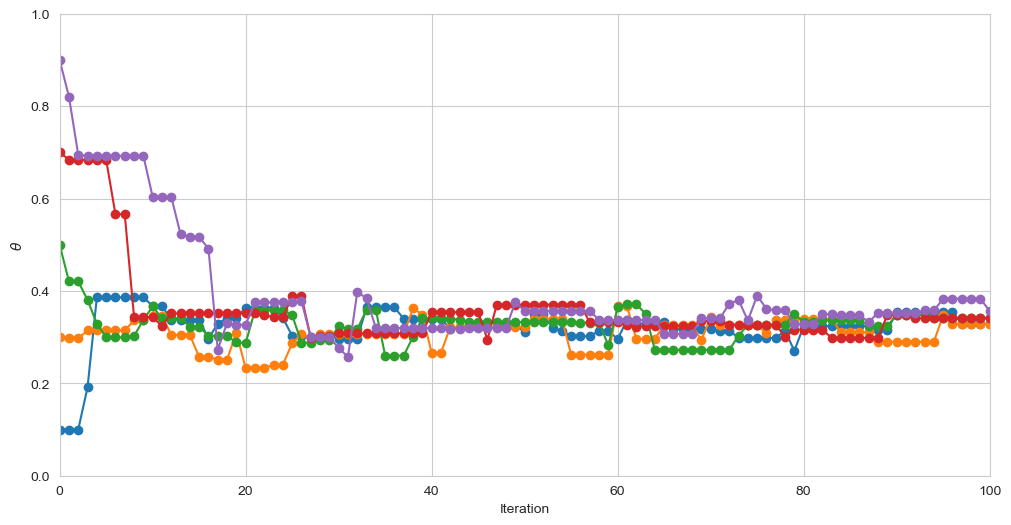

In [4]:
# distributions
alpha = 16
beta = alpha
likelihood = stats.binom
prior = stats.beta(alpha, beta)

num_iterations = 100

samples_5_sets = [data_generator(num_iterations, n, s,
                                 theta_0, likelihood, prior,
                                 drop_unstable=False,
                                 sigma=0.1)
                  for theta_0 in np.linspace(0.1, 0.9, 5)]

# Convergence of multiple MCMC chains

fig, ax = plt.subplots(figsize=(12, 6))

for data_idx in samples_5_sets:
    plt.plot(data_idx, '-o')

plt.xlim([0, num_iterations])
plt.xlabel('Iteration')
plt.ylim([0, 1]);
plt.ylabel(r'$\theta$')